# Solving the TOV Equation

In this exercise, we will solve the relativistic Tolman-Oppenheimer-Volkoff equation, which is obtained by solving Einstein's equation for a non-rotating, spherically symmetric, ideal fuid. Its solution descibes the global structure of a general relativistic, spherical object in hydrostatic equilibrium and is often used to obtain a simple model of neutron stars.

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
%matplotlib inline

# rc('text', usetex = True)
# rc('font', family = 'serif')
# mpl.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

To calculate numerical estimates we use the following natural constants. Note that these are defined in SI-units, so we convert them to cgs units.

In [2]:
from scipy.constants import pi, c, hbar, m_n, G
hbar = hbar*1e7
m_n = m_n*1e3
c = c *1e2
G = G*1e3
Msun = 1.98855e33
print(hbar, m_n, c, G)

1.0545718001391126e-27 1.674927471e-24 29979245800.0 6.67408e-08


## TOV Equation

The TOV equation reads

$$
\frac{dP(r)}{dr} = - \frac{G}{r^2} \left[ \rho(r) + \frac{P(r)}{c^2} \right] \left[m(r) + 4 \pi r^3 \frac{P(r)}{c^2} \right] \left[ 1 - \frac{2 G m(r)}{c^2 r} \right]^{-1},
$$

where $G$ and $c$ represent the gravitational constant and speed of light, respectively. Moreover, $r$ denotes the radial coordinate and $\rho(r)$ and $P(r)$ the mass density and pressure at position $r$, respectively. Finally, $m(r)$ is the gravitational mass (i.e. the mass measured by the gravitational field felt by a distant observer), which satisfies $m(0) = 0$ and is obtained by solving the continuity equation

$$
\frac{dm(r)}{dr}=4 \pi \rho(r) r^2 \hspace{1cm} \rightarrow \hspace{1cm} 
M = m(R) = \int_0^{R} 4 \pi \rho(r) r^2 \, d r ,
$$

with the stellar radius $r=R$. To solve the TOV equation and determine the structure of a simplified neutron star, we also need to provide an equation of state, relating pressure and density of the object, i.e. $P = P(\rho)$.  In the following, we will solve the TOV equation for a simplified equation of state.

## Two-component polytrope

As a simple neutron star model, we consider a sphere composed by non-interacting, degenerate neutrons which are characterised by two polytropic equations of state, i.e. one for the crust and one for the core with the boundary located at $\rho_{\rm b} \sim 3 \times 10^{14} \, \text{g} \, \text{cm}^{-3}$, i.e.

$$
P = \left\{ \begin{array}{ll} K_{\rm crust} \, \rho^{\gamma_{\rm crust}} & \text{for   } \rho < \rho_{\rm b}, \\ K_{\rm core} \, \rho^{\gamma_{\rm core}} & \text{for   } \rho > \rho_{\rm b}. \end{array} \right.
$$

We assume that the crust is pure degenerate neutron matter, described by the non-relativistic EoS

$$
P_{\rm crust} =  \frac{(3 \pi^2)^{2/3}}{5} \frac{\hbar^2}{m_n^{8/3}} \, \rho^{5/3}.
$$

For the core, we will try two different equations of state with different polytropic indices ($\gamma = 1 + 1/n$):

\begin{align}
&\text{stiff with} \hspace{0.5cm} \gamma_{\rm stiff} = 3, \hspace{0.5cm} n_{\rm stiff} = 1/2,\\[1.3ex]
&\text{soft with} \hspace{0.5cm} \gamma_{\rm soft} = 5/2, \hspace{0.5cm} n_{\rm soft} = 2/3 .
\end{align}

We also require continuity of the pressure at the crust-core interface, which gives the proportionality constant for the core EoS:

$$
K_{\rm core} = K_{\rm crust} \, \rho_{\rm b}^{\gamma_{\rm crust}-\gamma_{\rm core}}.
$$

In [3]:
gamma_crust = 5.0 / 3.0
gamma_core_stiff = 3.0
gamma_core_soft = 2.5
K_crust = (hbar**2. * (3.0 * pi**2.)**(2. / 3.)) / (5 * m_n**(8. / 3.))

In [4]:
rho_b = 3e14
P_b = K_crust*rho_b**gamma_crust

We need both $P(\rho)$ and the inverse $\rho(P)$, so we define two separate functions (negative densities/pressures are unphysical)

In [5]:
def eos(dens, gamma_core):
    """Equation of state taking the density and the adiabatic 
    index for the core EoS and returns the pressure"""
    
    K_core = K_crust * rho_b**(gamma_crust - gamma_core)
    
    if dens <= 0:
        return 0
    if dens < rho_b: 
        return K_crust * dens**gamma_crust
    else:
        return K_core * dens**gamma_core

In [6]:
def eos_inverse(pres, gamma_core):
    """Inverse equation of state taking the pressure and the adiabatic 
    index for the core EoS and returns the density"""
    
    K_core = K_crust * rho_b**(gamma_crust - gamma_core)
    
    if pres <= 0:
        return 0
    if pres < P_b:
        return (pres / K_crust)**(1.0 / gamma_crust)
    else:
        return (pres / K_core)**(1.0 / gamma_core)

As a check, compare

In [7]:
print(P_b)
print(eos(rho_b,gamma_core_stiff))
print(rho_b)
print(eos_inverse(P_b,gamma_core_stiff))

7.233398298443051e+33
7.233398298443053e+33
300000000000000.0
299999999999999.44


## Numerical solution

### Differential equations

We can write the two first order differential equations in a compact form by introducing the vector $\mathbf{y}=(P,m)^T$:

$$
\frac{d \mathbf{y}}{d r} = \frac{d}{d r} \left( \begin{array}{c} P \\ m \end{array} \right) = \left( \begin{array}{c} - \frac{G}{r^2} \left[ \rho(r) + \frac{P(r)}{c^2} \right] \left[m(r) + 4 \pi r^3 \frac{P(r)}{c^2} \right] \left[ 1 - \frac{2 G m(r)}{c^2 r} \right]^{-1} \\ 4 \pi \rho(r) r^2 \end{array} \right).
$$

In [8]:
def TOV(y,radius,gamma_core):
    """TOV equations"""
    
    P = y[0]
    m = y[1]
    rho = eos_inverse(P,gamma_core)
    
    dPdr = -G * (rho + P / c**2.) * (m + 4.0 * pi * radius**3. * P / c**2.) / (radius * (radius - 2.0 * G * m / c**2.))
    dmdr = 4.0 * pi * radius**2. * rho
    dydr = np.array([dPdr, dmdr])
    
    return dydr

To integrate this system with respect to the radial variable $r$, we have to specify the mass and pressure at $r=0$. To do this, either a central density or pressure (as both are related by the EoS) can be chosen. We will calculate the star's mass and radius for a typical range of central densities.

### Numerical integration

To solve the initial value problem use `odeint`:

In [9]:
dr = 1e2
r = np.arange(dr, 2e6, dr)

In [10]:
def solve_TOV(radius, dens_central, gamma_core):
    """Function takes a radius array, central density and the adiabatic 
    index for the core EoS and solves the TOV equation"""
    
    # setting the initial values at r=0
    P0 = eos(dens_central, gamma_core)
    m0 = 4.0 * pi * radius[0]**3. * dens_central / 3.0
    y0 = np.array([P0, m0])
    
    # adjust the maximum step size for integration
    y = odeint(TOV, y0, radius, args=(gamma_core,), mxstep=500000)
    
    # remove negative pressures, i.e. truncate at stellar surface
    y = y[y[:, 0] > 0]
    return y

In [11]:
print(solve_TOV(r, 1e15, gamma_core_stiff))

[[2.67903641e+35 4.18879020e+21]
 [2.67903630e+35 3.35103215e+22]
 [2.67903613e+35 1.13097333e+23]
 ...
 [6.31361227e+26 4.35145980e+33]
 [2.03926321e+26 4.35145982e+33]
 [2.45261288e+25 4.35145984e+33]]


### Pressure and mass behaviour

Plot the results as a function of radius to compare soft and stiff core equations of state for a central density $\rho_c = 10^{15} \, \text{g} \, \text{cm}^{-3}$. For convencience express the radial coordinate in kilometers and introduce the dimensionless quantities $\bar{P} = P / P_c$ ($P_c$ is the central pressure) and $\bar{M} = M/M_{\odot}$.

In [12]:
P_c_stiff = eos(1e15, gamma_core_stiff)
Pbar_stiff = solve_TOV(r,1e15, gamma_core_stiff)[:,0] / (P_c_stiff)
P_c_soft = eos(1e15, gamma_core_soft)
Pbar_soft = solve_TOV(r,1e15, gamma_core_soft)[:,0]/(P_c_soft)
rbar = r/1e5

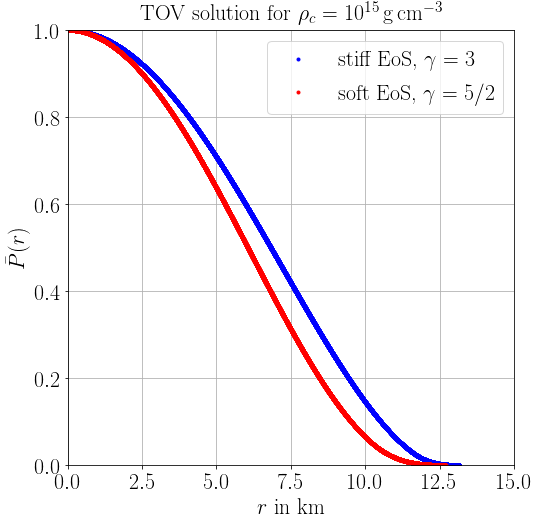

In [13]:
fig = plt.figure()
fig.set_size_inches(8,8)
mpl.rcParams.update({'font.size': 22})
colour = ('red','blue','green','yellow','brown','purple')
plt.title(r'TOV solution for $\rho_c = 10^{15} \,$g$\,$cm$^{-3}$', fontsize = 22)

plt.plot(rbar[:len(Pbar_stiff)], Pbar_stiff, '.', color='blue', label=r"stiff EoS, $\gamma=3$")
plt.plot(rbar[:len(Pbar_soft)], Pbar_soft, '.', color='red', label=r"soft EoS, $\gamma=5/2$")

plt.xlim(0,15)
plt.ylim(0,1)
plt.xlabel(r'$r$ in km')
plt.ylabel(r'$\bar{P}(r)$')
plt.grid()

plt.legend(loc = 1);
plt.show()

In [14]:
Mbar_stiff = solve_TOV(r, 1e15, gamma_core_stiff)[:,1] / Msun
Mbar_soft = solve_TOV(r, 1e15, gamma_core_soft)[:,1] / Msun

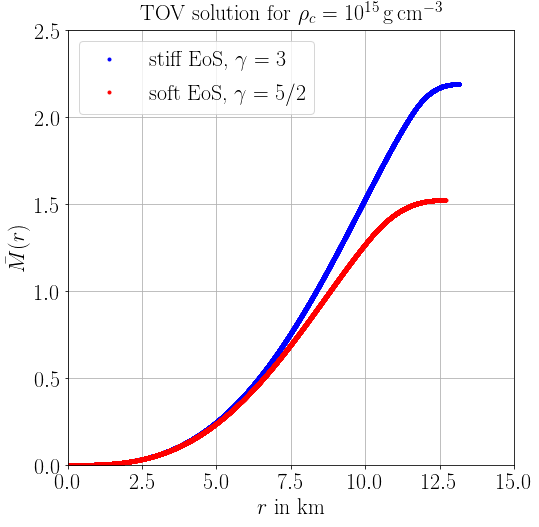

In [15]:
fig=plt.figure()
fig.set_size_inches(8,8)
mpl.rcParams.update({'font.size': 22})
colour = ('red','blue','green','yellow','brown','purple')
plt.title(r'TOV solution for $\rho_c = 10^{15} \,$g$\,$cm$^{-3}$', fontsize = 22)

plt.plot(rbar[:len(Mbar_stiff)], Mbar_stiff, '.', color='blue', label=r"stiff EoS, $\gamma=3$")
plt.plot(rbar[:len(Mbar_soft)], Mbar_soft, '.', color='red', label=r"soft EoS, $\gamma=5/2$")

plt.xlim(0,15)
plt.ylim(0,2.5)
plt.xlabel(r'$r$ in km')
plt.ylabel(r'$\bar{M}(r)$')
plt.grid()

plt.legend(loc = 2);
plt.show()

### Mass-radius relations

Determine $R$, i.e. the surface of the star, as the entry in the $r$ array, where density and pressure drop below zero and we have cut off our solution $\mathbf{y}$.

In [16]:
def EoS_parameters(radius, dens_central, gamma_core):
    """Function takes a central density and the adiabatic index for 
    the core EoS and returns the star's mass and radius"""
    
    y = solve_TOV(radius, dens_central, gamma_core)
    M_star = y[-1 ,1]
    R_star = radius[len(y)-1]
    
    return M_star / Msun, R_star / 1e5

In [17]:
print(EoS_parameters(r, 3e15, gamma_core_stiff))

(2.6622117693287666, 10.539)


Determine mass-radius relations $M(R)$ for our stiff and soft core equations of state by selecting a range of central densities (start slightly above the boundary value $\rho_{\rm boundary} \sim 3 \times 10^{14} \, \text{g} \, \text{cm}^{-3}$):

In [18]:
rho_c = np.logspace(14.5, 17, num=150)

In [19]:
R_stiff = np.zeros(len(rho_c))
M_stiff = np.zeros(len(rho_c))
R_soft = np.zeros(len(rho_c))
M_soft = np.zeros(len(rho_c))

for i, rho in enumerate(rho_c):
    M_stiff[i], R_stiff[i] = EoS_parameters(r, rho, gamma_core_stiff)
    M_soft[i], R_soft[i] = EoS_parameters(r, rho, gamma_core_soft)

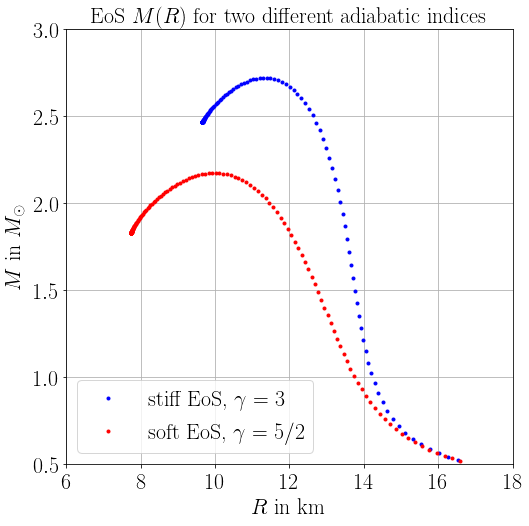

In [20]:
fig = plt.figure()
fig.set_size_inches(8,8)
mpl.rcParams.update({'font.size': 22})
colour = ('red','blue','green','yellow','brown','purple')
plt.title(r'EoS $M(R)$ for two different adiabatic indices', fontsize=22)

plt.plot(R_stiff,M_stiff, '.', color='blue', label=r"stiff EoS, $\gamma=3$")
plt.plot(R_soft,M_soft, '.', color='red', label=r"soft EoS, $\gamma=5/2$")

plt.xlim(6,18)
plt.ylim(0.5,3)
plt.xlabel(r'$R$ in km')
plt.ylabel(r'$M$ in $M_{\odot}$')
plt.grid()

plt.legend(loc=3);
plt.show()

As expected, the softer EoS describes smaller maximum masses as well as smaller masses for a specific radii than the stiffer EoS.